In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import time

In [2]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
feature = pd.read_csv('train.csv', nrows=0)



In [3]:
def Drop_col(data):
    columns = ["UvAerosolLayerHeight_aerosol_height", "UvAerosolLayerHeight_aerosol_pressure", "UvAerosolLayerHeight_aerosol_optical_depth",
               "UvAerosolLayerHeight_sensor_zenith_angle", "UvAerosolLayerHeight_sensor_azimuth_angle", "UvAerosolLayerHeight_solar_azimuth_angle",
               "UvAerosolLayerHeight_solar_zenith_angle", "ID_LAT_LON_YEAR_WEEK"]
    for col in columns:
        data.drop(columns=col, axis=1, inplace=True)
    return data

train = Drop_col(train)
test = Drop_col(test)
feature = Drop_col(feature)



In [4]:
#Replace Nan value with median
def Fill_Data(data):
    for x in data.columns:
        data[x] = data[x].fillna(data[x].median())
    return data

train = Fill_Data(train)
test = Fill_Data(test)

In [5]:
X = train.drop(columns="emission",axis=1)
Y = train["emission"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feature_names = [f"feature {i}" for i in range(X.shape[1])]

In [7]:
feature=list(feature)
feature.remove("emission")


In [8]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time



In [9]:
train_no2020 = train[train['year'] != 2020.000000]
X_no2020 = train_no2020.drop(columns="emission",axis=1)
Y_no2020 = train_no2020["emission"]


In [10]:
feature_important = [(feature[i], importances[i]) for i in range(X.shape[1]) if importances[i] > 0.003]
print(feature_important)
print(len(feature_important))
feature_important_name = [feature[i] for i in range(X.shape[1]) if importances[i] > 0.003]
print(feature_important_name)

[('latitude', 0.16657999249692923), ('longitude', 0.7317814603591593), ('week_no', 0.06521304271188798), ('Ozone_O3_column_number_density', 0.003446208832746482)]
4
['latitude', 'longitude', 'week_no', 'Ozone_O3_column_number_density']


In [11]:
X_no2020 = train_no2020[feature_important_name]


In [12]:
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(X_no2020,Y_no2020,train_size=0.7, random_state=42)

In [13]:
from sklearn.preprocessing import MinMaxScaler


min_max_scaler = MinMaxScaler()
x_train_red = min_max_scaler.fit_transform(x_train_red)
x_test_red = min_max_scaler.transform(x_test_red)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [15]:
model3 = Sequential()
model3.add(Dense(1000, input_shape=(X_no2020.shape[1],), activation='relu')) # (features,)
model3.add(Dense(750, activation='relu')) 
model3.add(Dense(500, activation='relu'))
model3.add(Dense(1, activation='linear')) # output node
model3.summary() # see what your model looks like

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              5000      
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1131751 (4.32 MB)
Trainable params: 1131751 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
history = model3.fit(x_train_red, y_train_red,validation_data = (x_test_red, y_test_red),
                    epochs=500,
                    batch_size=20,
                    )

Epoch 1/500
1844/1844 [==============================] - 16s 8ms/step - loss: 20283.1934 - mse: 20283.1934 - val_loss: 18792.0664 - val_mse: 18792.0664
Epoch 2/500
1844/1844 [==============================] - 15s 8ms/step - loss: 19348.6875 - mse: 19348.6875 - val_loss: 18684.9316 - val_mse: 18684.9316
Epoch 3/500
1844/1844 [==============================] - 15s 8ms/step - loss: 19054.7812 - mse: 19054.7812 - val_loss: 18171.3203 - val_mse: 18171.3203
Epoch 4/500
1844/1844 [==============================] - 15s 8ms/step - loss: 18807.5742 - mse: 18807.5742 - val_loss: 17562.5078 - val_mse: 17562.5078
Epoch 5/500
1844/1844 [==============================] - 16s 9ms/step - loss: 18607.1582 - mse: 18607.1582 - val_loss: 18166.1328 - val_mse: 18166.1328
Epoch 6/500
1844/1844 [==============================] - 16s 9ms/step - loss: 18416.6426 - mse: 18416.6426 - val_loss: 17444.3965 - val_mse: 17444.3965
Epoch 7/500
1844/1844 [==============================] - 16s 9ms/step - loss: 18287.4844

494/494 [==============================] - 1s 2ms/step


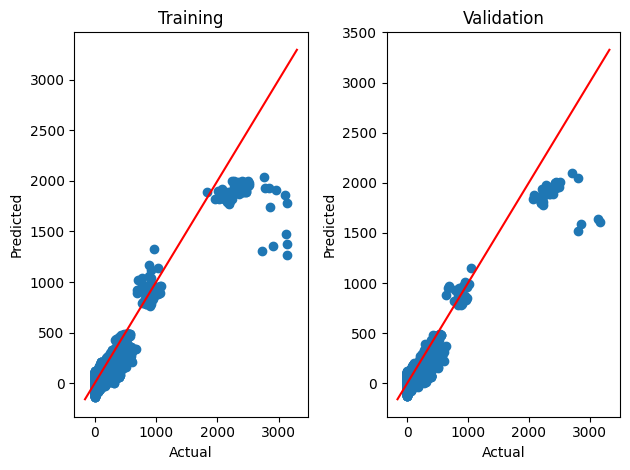

In [17]:

# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train_red, y=model3.predict(x_train_red)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test_red, y=model3.predict(x_test_red)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [19]:
pred = model3.predict(x_test_red)
pred

trainpreds = model3.predict(x_train_red)

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
NN_score = r2_score(y_test_red,pred)
print(mean_absolute_error(y_train_red, trainpreds)) # train
print(mean_absolute_error(y_test_red, pred)) # test
print(r2_score(y_test_red,pred))

1153/1153 [==============================] - 2s 2ms/step
32.47979501567605
32.196557067807646
0.8533191029217988


In [20]:
import xgboost as xgb
def train_xgboost_model(X_train, y_train, X_val, y_val, iteration):
    xg_train = xgb.DMatrix(X_train, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    iteration = iteration
    eval_results = {}

    def eval_metric_rmse(preds, train):
        labels = train.get_label()
        rmse = mean_squared_error(labels, preds, squared=False)
        return 'rmse', rmse

    model_xgb = xgb.train(params, xg_train, iteration, evals=[(xg_train, 'Train'), (xg_val, 'Validation')],
                          early_stopping_rounds=10, evals_result=eval_results, feval=eval_metric_rmse, verbose_eval=True)

    y_pred_xgb = model_xgb.predict(xg_val)
    xgb_score = r2_score(y_val, y_pred_xgb)
    rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
    print(f"XGBoost RMSE: {rmse_xgb}")
    print(f'XGBoost Accuracy: {r2_score(y_val, y_pred_xgb)}')

    # Plotting RMSE for each round
    train_rmse = eval_results['Train']['rmse']
    val_rmse = eval_results['Validation']['rmse']

    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.ylabel('RMSE')
    plt.title('RMSE per Round during XGBoost Training')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, iteration)
    plt.show()

    return model_xgb, eval_results, rmse_xgb, y_pred_xgb,xgb_score

[0]	Train-rmse:143.11189	Validation-rmse:142.30948


[1]	Train-rmse:138.96915	Validation-rmse:138.33813
[2]	Train-rmse:131.59727	Validation-rmse:131.25046
[3]	Train-rmse:125.11644	Validation-rmse:125.00875
[4]	Train-rmse:119.54198	Validation-rmse:119.63872
[5]	Train-rmse:113.65530	Validation-rmse:113.96668
[6]	Train-rmse:109.49017	Validation-rmse:109.94163
[7]	Train-rmse:105.89957	Validation-rmse:106.98676
[8]	Train-rmse:103.26568	Validation-rmse:104.47317
[9]	Train-rmse:101.08321	Validation-rmse:102.40789
[10]	Train-rmse:99.20529	Validation-rmse:100.64977
[11]	Train-rmse:98.17747	Validation-rmse:99.66162
[12]	Train-rmse:95.33483	Validation-rmse:96.89036
[13]	Train-rmse:92.11425	Validation-rmse:93.64584
[14]	Train-rmse:91.65287	Validation-rmse:93.20383
[15]	Train-rmse:91.37354	Validation-rmse:92.94484
[16]	Train-rmse:89.70272	Validation-rmse:91.23895
[17]	Train-rmse:85.82861	Validation-rmse:87.43456
[18]	Train-rmse:81.96056	Validation-rmse:83.43975
[19]	Train-rmse:79.39527	Validation-rmse:80.87267
[20]	Train-rmse:78.23115	Validation-rmse

C:\Users\hoyou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[23]	Train-rmse:74.81521	Validation-rmse:76.30421
[24]	Train-rmse:72.82492	Validation-rmse:74.59846
[25]	Train-rmse:71.99476	Validation-rmse:73.74081
[26]	Train-rmse:71.15188	Validation-rmse:72.87744
[27]	Train-rmse:70.91530	Validation-rmse:72.65170
[28]	Train-rmse:70.59374	Validation-rmse:72.39630
[29]	Train-rmse:69.88493	Validation-rmse:71.62122
[30]	Train-rmse:68.35000	Validation-rmse:69.99634
[31]	Train-rmse:66.93767	Validation-rmse:68.53577
[32]	Train-rmse:66.76709	Validation-rmse:68.40753
[33]	Train-rmse:66.33058	Validation-rmse:67.92790
[34]	Train-rmse:66.03296	Validation-rmse:67.72690
[35]	Train-rmse:65.46635	Validation-rmse:67.13838
[36]	Train-rmse:64.55266	Validation-rmse:66.36682
[37]	Train-rmse:64.15142	Validation-rmse:65.90778
[38]	Train-rmse:62.00870	Validation-rmse:63.57526
[39]	Train-rmse:60.66797	Validation-rmse:62.20374
[40]	Train-rmse:60.11280	Validation-rmse:61.66880
[41]	Train-rmse:59.75535	Validation-rmse:61.37328
[42]	Train-rmse:59.45385	Validation-rmse:61.05765


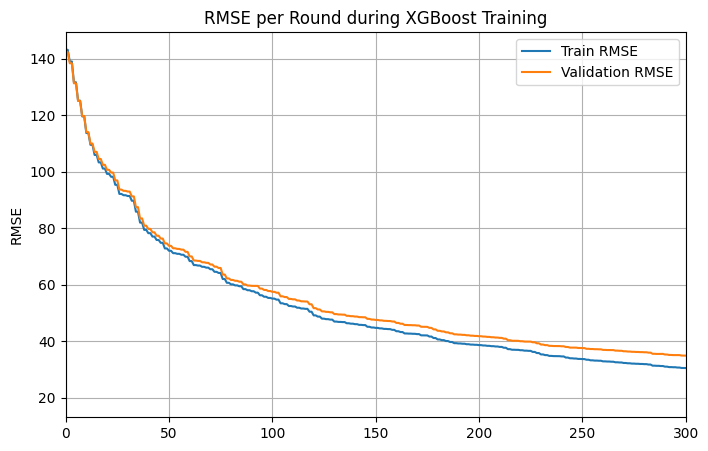

In [21]:
model_xg3, eval_results3, rmse3, y_pred_xg3,xgb_rscore = train_xgboost_model(x_train_red, y_train_red, x_test_red, y_test_red, 300)

In [ ]:
forest2 = RandomForestRegressor(random_state=42)
forest2.fit(x_train_red, y_train_red)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred_rf = forest2.predict(x_test_red)
rf_score = r2_score(y_test_red, y_pred_rf)
print(rf_score)

0.9795562908731521


25.866211402691555


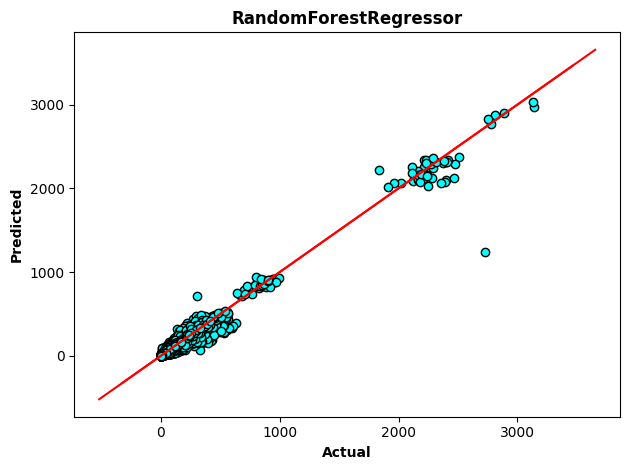

In [33]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots() # 1 row, 2 columns


axes.plot(x, x, color='red')
# Validation Results
axes.scatter(x=y_test, y=forest.predict(X_test),color = 'cyan', edgecolor='k') # first row, second entry (right top)
axes.set_xlabel("Actual", fontsize=10, fontweight='bold')
axes.set_ylabel("Predicted",  fontsize=10, fontweight='bold')
axes.set_title('RandomForestRegressor', fontweight='bold')
# add 45 deg line
x = np.linspace(*axes.get_xlim())
axes.plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()